In [1]:
# Python version with simple smoothiing to create spherical illustration of spatial heterogeneity on spin testing 

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import gstools as gs 
import meshio       
from icosphere import icosphere
seed = gs.random.MasterRNG(20170525)
from scipy.stats._stats_py import _chk2_asarray # This was so netneurotools would work. May not be necessary

from netneurotools import stats as statsNNT 
import helpers
import scipy, math
from sklearn.metrics import DistanceMetric
from scipy import special


# Helper functions

def normData(data): # standardise data
    data_mu=data.mean()
    data_s=data.std()
    return (data-data_mu)/data_s;
    
def appendSpherical_np(xyz):
# this function turns it from cartesian coordinates (x,y,z) into lontitude and latitude taken from https://pyquestions.com/faster-numpy-cartesian-to-spherical-coordinate-conversion
    ptsnew = np.hstack((xyz, np.zeros(xyz.shape)))
    xy = xyz[:, 0]**2 + xyz[:, 1]**2
    ptsnew[:, 3] = np.sqrt(xy + xyz[:, 2]**2)
    ptsnew[:, 4] = np.arctan2(xyz[:, 2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    ptsnew[:, 5] = np.arctan2(xyz[:, 1], xyz[:, 0])
    return ptsnew

def emp_variogram(x, D, nh, h_bounds = 0):
# calculate the empirical variogram adapted from BrainSMASH... 
    n = x.size
    triu = np.triu_indices(n, k = 1)  # upper triangular inds
    b = 3

    diff_ij = np.subtract.outer(x, x)
    v = 0.5 * np.square(diff_ij)[triu]
    u = D[triu]

    if h_bounds == 0:
        h = np.linspace(u.min(), u.max(), nh)
    else: 
        h = np.linspace(h_bounds[0], h_bounds[1], nh)

    # Subtract each h from each pairwise distance u
    # Each row corresponds to a unique h

    du = np.abs(u - h[:, None])
    w = np.exp(- np.square(2.68 * du / b) / 2)
    denom = np.nansum(w, axis = 1)
    wv = w * v[None, :]
    num = np.nansum(wv, axis = 1)
    ev = num / denom #empirical variogram
    return h, ev

def emp_cross_variogram(x1, x2, D, nh, h_bounds=0):
# calculate the empirical cross-variogram, adapted from emp_variogram
    n = x1.shape[0]
    triu = np.triu_indices(n, k=1)  # upper triangular inds
    b = 3

    diff_ij_1 = np.subtract.outer(x1, x1)
    diff_ij_2 = np.subtract.outer(x2, x2)
    #v1 = 0.5 * np.square(diff_ij_1)[triu]
    #v2 = 0.5 * np.square(diff_ij_2)[triu]
    v1 = np.square(diff_ij_1)[triu]
    v2 = np.square(diff_ij_2)[triu]

    
    v = 0.5 * v1 * v2
    u = D[triu]

    if h_bounds == 0:
        h = np.linspace(u.min(), u.max(), nh)
    else:
        h = np.linspace(h_bounds[0], h_bounds[1], nh)

    # Subtract each h from each pairwise distance u
    # Each row corresponds to a unique h

    du = np.abs(u - h[:, None])
    w = np.exp(- np.square(2.68 * du / b) / 2)
    denom = np.nansum(w, axis=1)
    wv = w * v[None, :]
    num = np.nansum(wv, axis=1)
    ev = num / denom # empirical variogram
    return h,ev


def plot_mean_std(y_mean,y_stddev,x,show=1): # Simple plotting function
    y_upper = y_mean + y_stddev
    y_lower = y_mean - y_stddev

    # plot mean
    plt.plot(x, y_mean, label='Mean')

    # fill between upper and lower bounds
    plt.fill_between(x, y_upper, y_lower, alpha=0.2, label='StErr')

    plt.legend()
    if show:
        plt.show()


def gb(x, mu, sig): # for gaussian smoothing
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


In [2]:
# Create an icosphere to populate with data
#points, cells = meshzoo.icosa_sphere(7) # create an icosphere to put the data on.
nu = 8  # or any other integer
points, cells = icosphere(nu)
ptsnew = appendSpherical_np(points) #Calculate haversine distance (i.e., approximate distance along the sphere's surface)
dist = DistanceMetric.get_metric('haversine') 
distMat = dist.pairwise(ptsnew[:, 4:6], ptsnew[:, 4:6]) # Surface distance matrix

# Also euclidean distance in case we want to use this
distE=DistanceMetric.get_metric('euclidean')
distMatE = distE.pairwise(points, points)

num_rotations=100 # Generate random spins on the sphere.
spins=statsNNT.gen_spinsamples(points,np.zeros(points.shape[0]),n_rotate=num_rotations,exact=True,method='hungarian')

In [3]:
# Create spherical surfaces with different types of heterogeneity

HighSA=0.2 # the spatial autocorrelation length in radians, with long length scale

RandNoSmooth=np.random.randn(points.shape[0]) # Generate non-spatial white noise 
RandSmooth=RandNoSmooth.copy()

for i in range(points.shape[0]): # Smooth the random data by HighSA. 
    RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,HighSA))

SA_1=RandSmooth # SA_1 is first spherical map with high length scale

RandNoSmooth=np.random.randn(points.shape[0])
RandSmooth=RandNoSmooth.copy()

for i in range(points.shape[0]):
    RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,HighSA))

SA_2=RandSmooth # SA_2 is an independent spherical map generated by smoothing a different set of random data. Absent spatial autocorrelation, these maps would be unrelated

LowSA=0.1 # Repeat the same process but with a much lower length scale

RandNoSmooth=np.random.randn(points.shape[0])
RandSmooth=RandNoSmooth.copy()

for i in range(points.shape[0]):
    RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,LowSA))

SA_1_LA=RandSmooth

RandNoSmooth=np.random.randn(points.shape[0])
RandSmooth=RandNoSmooth.copy()

for i in range(points.shape[0]):
    RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,LowSA))

SA_2_LA=RandSmooth

# Merging the two maps to create heterogeneous spatial dependency. 
points_dataMixed1=np.zeros(SA_1.shape) 
points_dataMixed2=np.zeros(SA_1.shape)

FirstHalf=points[:,0]<0 # For simplicity (there's probably much better ways), we just take points whose positions are greater or less than x=0
SecondHalf=points[:,0]>=0

points_dataMixed1[FirstHalf]=normData(SA_1[FirstHalf]) # Combine the x<0 and x>0 halves of the high and low SA maps
points_dataMixed1[SecondHalf]=normData(SA_1_LA[SecondHalf])
points_dataMixed2[FirstHalf]=normData(SA_2[FirstHalf])
points_dataMixed2[SecondHalf]=normData(SA_2_LA[SecondHalf])

#plt.scatter(points_dataMixed1.reshape(-1,1),points_dataMixed2.reshape(-1,1))
#points_dataMixed2.shape
np.savetxt('./SimData1.txt', points_dataMixed1)
np.savetxt('./SimData2.txt', points_dataMixed2)
np.savetxt('./SimDataLocs.txt', points)


In [14]:
# Same process as above but for without any heterogeneity in spatial autocorrelation (so no mixing of long and short SA, instead all high SA).
iterations=500
bins=20
num_rotations=100
PermResultsNoNS=[]
MeasCorrResultsNoNS=[]
MeasEVResultsNoNS=np.zeros([bins,iterations])
MeasECVResultsNoNS=np.zeros([bins,iterations])
ShuffEVResultsNoNS=np.zeros([bins,num_rotations,iterations])
ShuffECVResultsNoNS=np.zeros([bins,num_rotations,iterations])


for k in range(iterations):
    
    HighSA=1 
    
    
    RandNoSmooth=np.random.randn(points.shape[0])
    RandSmooth=RandNoSmooth.copy()

    for i in range(points.shape[0]):
        RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,HighSA))

    SA_1=normData(RandSmooth)

    RandNoSmooth=np.random.randn(points.shape[0])
    RandSmooth=RandNoSmooth.copy()

    for i in range(points.shape[0]):
        RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,HighSA))
    
    SA_2=normData(RandSmooth)
    
    MeasureCorr=stats.spearmanr(SA_1,SA_2)[0] 


    

    ShuffCor=np.zeros(spins.shape[1])
    ShuffV=np.zeros([bins,num_rotations])
    ShuffCV=np.zeros([bins,num_rotations])
    for j in range(spins.shape[1]):    


        Shuffpoints_dataMixed=SA_1[spins[:,j]]



        ShuffCor[j]=stats.spearmanr(Shuffpoints_dataMixed,SA_2)[0]
        h, ShuffV[:,j] = emp_variogram(Shuffpoints_dataMixed, distMat*10, bins)
        h, ShuffCV[:,j] = emp_cross_variogram(Shuffpoints_dataMixed, SA_2,distMat*10, bins)

    h, ev = emp_variogram(SA_1, distMat*10, bins)
    ShuffEVResultsNoNS[:,:,k]=ShuffV
    ShuffECVResultsNoNS[:,:,k]=ShuffCV
    MeasEVResultsNoNS[:,k]=ev
    h, ev = emp_cross_variogram(SA_1, SA_2,distMat*10, bins)
    MeasECVResultsNoNS[:,k]=ev
    MeasCorrResultsNoNS.append(MeasureCorr)
    PermResultsNoNS.append(np.sum(MeasureCorr>ShuffCor)) # calculate the number of true correlations with a greater corr than shuffled

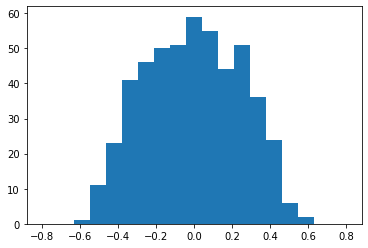

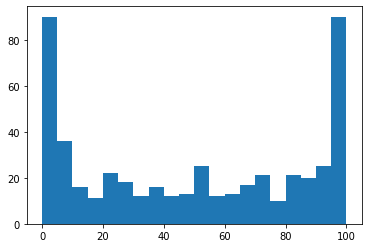

In [104]:
# Spatial heterogeneous situation. Histogram of true correlations (top)
# Spin test does not correct for this (bottom) with more true big +ve or -ve correlations than expected by spin permutations.

plt.hist(MeasCorrResults,bins=np.linspace(-0.8,0.8,20))
#print(np.mean(MeasCorrResults))
plt.pause(0.01)
plt.hist(PermResults,bins=20);

#print(np.logical_xor(np.asarray(PermResults)<5,np.asarray(PermResults)>95).sum())




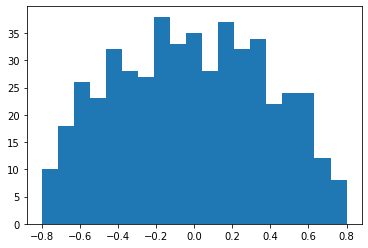

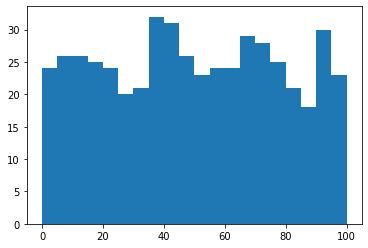

In [105]:
# Non-heterogeneous situation. Tthere are higher correlation values (top) (positive and negative) for the true correlations, 
# but the spin test corrects fro these, so more tests are not rejected than expected by chance (bottom). 

plt.hist(MeasCorrResultsNoNS, bins=np.linspace(-0.8,0.8,20))
#print(np.mean(MeasCorrResultsNoNS))
plt.pause(0.01)
plt.hist(PermResultsNoNS,bins=20);

#print(np.logical_xor(np.asarray(PermResultsNoNS)<5,np.asarray(PermResultsNoNS)>95).sum())


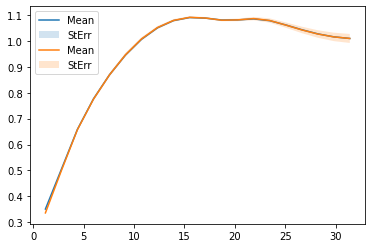

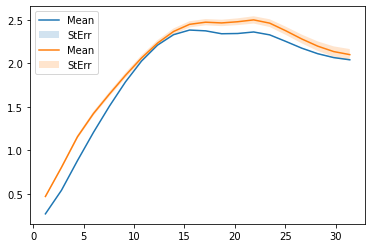

In [92]:
# Plot mean variogram (top) and cross-variogram (bottom) for spatial heterogeneity situation across all shuffles and repetitions
# Shuffled and true variograms perfectly overlap, but not the cross-variograms.

y_mean=np.mean(np.mean(ShuffEVResults,axis=1),axis=1)
y_std=np.std(ShuffEVResults.reshape(20,500*100),axis=1)/np.power(500*100,0.5)*2
#y_std=np.std(ShuffEVResults.reshape(20,500*100),axis=1)
x=h

plot_mean_std(y_mean,y_std,x,0)

yReal=np.mean(MeasEVResults,axis=1)
yRealStd=np.std(MeasEVResults,axis=1)/np.power(500,0.5)*2
#yRealStd=np.std(MeasEVResults,axis=1)

plot_mean_std(yReal,yRealStd,x)


y_mean=np.mean(np.mean(ShuffECVResults,axis=1),axis=1)
y_std=np.std(ShuffECVResults.reshape(20,500*100),axis=1)/np.power(500*100,0.5)*2
#y_std=np.std(ShuffECVResults.reshape(20,500*100),axis=1)
x=h

plot_mean_std(y_mean,y_std,x,0)

yReal=np.mean(MeasECVResults,axis=1)
yRealStd=np.std(MeasECVResults,axis=1)/np.power(500,0.5)*2
#yRealStd=np.std(MeasECVResults,axis=1)

plot_mean_std(yReal,yRealStd,x)


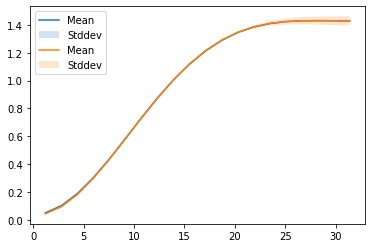

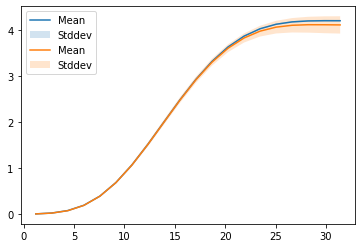

In [17]:
# Plot mean variogram (top) and cross-variogram (bottom) for no spatial heterogeneity across all shuffles and repetitions
# Shuffled and true perfectly overlap.

y_mean=np.mean(np.mean(ShuffEVResultsNoNS,axis=1),axis=1)
y_std=(np.std(ShuffEVResultsNoNS.reshape(20,500*100),axis=1))//np.power(500*100,0.5)*2
#y_std=(np.std(np.std(ShuffEVResultsNoNS,axis=1),axis=1))/np.power(500,0.5)

x=h


plot_mean_std(y_mean,y_std,x,0)

yReal=np.mean(MeasEVResultsNoNS,axis=1)
yRealStd=(np.std(MeasEVResultsNoNS,axis=1))/np.power(500,0.5)*2

plot_mean_std(yReal,yRealStd,x)


y_mean=np.mean(np.mean(ShuffECVResultsNoNS,axis=1),axis=1)
y_std=(np.std(ShuffECVResultsNoNS.reshape(20,500*100),axis=1))/np.power(500*100,0.5)*2
#y_std=(np.std(np.std(ShuffECVResultsNoNS,axis=1),axis=1))/np.power(500,0.5)
x=h

plot_mean_std(y_mean,y_std,x,0)

yReal=np.mean(MeasECVResultsNoNS,axis=1)
yRealStd=np.std(MeasECVResultsNoNS,axis=1)/np.power(500,0.5)*2

plot_mean_std(yReal,yRealStd,x)


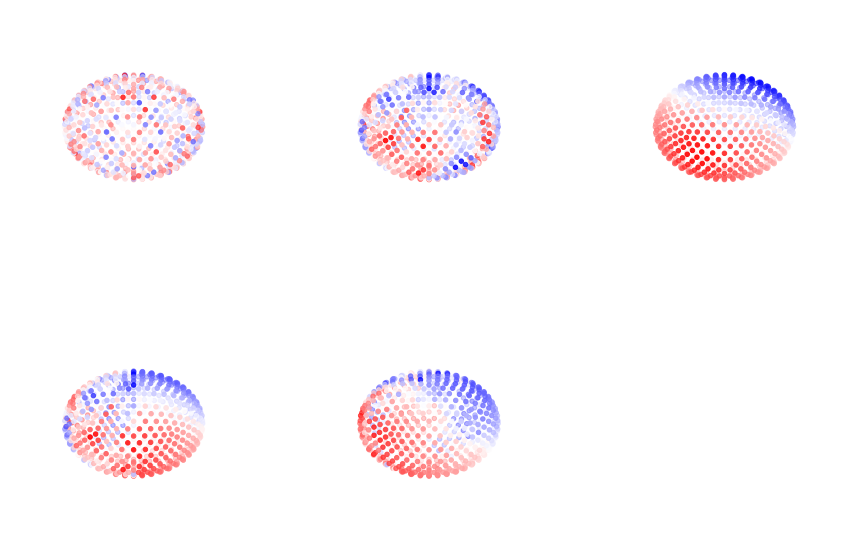

In [91]:
RandNoSmooth=np.random.randn(points.shape[0])
RandSmooth=RandNoSmooth.copy()
s=20
LowSA=0.1
HighSA=1
for i in range(points.shape[0]):
    RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,LowSA))

SA_1_LA=RandSmooth.copy()

for i in range(points.shape[0]):
    RandSmooth[i]=np.mean(RandNoSmooth*gb(distMat[i,:],1,HighSA))

SA_1=RandSmooth.copy()

points_dataMixed1[FirstHalf]=normData(SA_1[FirstHalf]) # Combine the x<0 and x>0 halves of the high and low SA maps
points_dataMixed1[SecondHalf]=normData(SA_1_LA[SecondHalf])


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(231, projection = '3d')
ax.grid(False)
ax.set_axis_off()
ax.scatter(points[:,0], points[:,1], points[:,2],c=RandNoSmooth,cmap='bwr',s=s)


ax.view_init(10,90)



ax = fig.add_subplot(232, projection = '3d')
ax.grid(False)
ax.view_init(10,90)
ax.scatter(points[:,0], points[:,1], points[:,2],c=SA_1_LA,cmap='bwr',s=s)


ax.set_axis_off()

ax = fig.add_subplot(233, projection = '3d')
ax.grid(False)

ax.set_axis_off()
ax.scatter(points[:,0], points[:,1], points[:,2],c=SA_1,cmap='bwr',s=s)



ax.view_init(10,90)




#plt.show()

#fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(234, projection = '3d')
ax.grid(False)
ax.set_axis_off()
ax.scatter(points[:,0], points[:,1], points[:,2],c=points_dataMixed1,cmap='bwr',s=s)
#ax.scatter(points[:,0], points[:,1], points[:,2],c=points_dataMixed1[spins[:,15]])

#ax.scatter(points[:,0], points[:,1], points[:,2],c=SA_2)

#ax.view_init(-20,150)
ax.view_init(10,90)

ax = fig.add_subplot(235, projection = '3d')
ax.grid(False)
ax.set_axis_off()
#ax.scatter(points[:,0], points[:,1], points[:,2],c=points_dataMixed2)
ax.scatter(points[:,0], points[:,1], points[:,2],c=points_dataMixed1[spins[:,2]],cmap='bwr',s=s)

#ax.scatter(points[:,0], points[:,1], points[:,2],c=SA_2)

#ax.view_init(-20,150)
ax.view_init(10,90)
plt.savefig('RandIllustration.png', dpi=300)

